In [1]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import os
import pandas as pd

In [2]:
df = pd.read_csv('./train.csv')

In [3]:
# Load data

data = df.values.astype(np.float32)
np.random.shuffle(data)
X = data[:, 1:]
Y = data[:, 0]

Xtrain = X[:-1000]
Ytrain = Y[:-1000]
Xtest  = X[-1000:]
Ytest  = Y[-1000:]

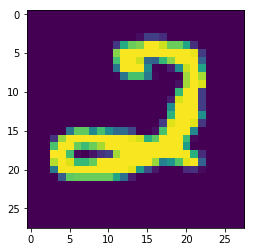

In [4]:
s = np.reshape(Xtrain[0], (28, 28))
plt.imshow(s)
plt.show()

In [5]:
# normalizie the data

mu = Xtrain.mean(axis=0)
std = Xtrain.std(axis=0)

np.place(std, std == 0, 1)

Xtrain = (Xtrain - mu) / std
Xtest = (Xtest - mu) / std

In [6]:
# change y to hot encoder

def y2indicator(y):

    y = y.astype(np.int32)
    ind = np.zeros((len(y), 10))

    for i in range(len(y)):
        ind[i, y[i]] = 1
        
    return ind 

In [7]:
Ytrain_ind = y2indicator(Ytrain)
Ytest_ind = y2indicator(Ytest)

In [8]:
# data is ready

Xtrain = Xtrain.astype(np.float32)
Xtest = Xtest.astype(np.float32)
Ytrain = Ytrain.astype(np.float32)
Ytest = Ytest.astype(np.float32)
Ytrain_ind = Ytrain_ind.astype(np.float32)
Ytest_ind = Ytest_ind.astype(np.float32)

In [9]:
max_iter = 15
print_period = 100

lr = 0.00004
reg = 0.01

N, D = Xtrain.shape
batch_sz = 500
n_batches = N // batch_sz

# add an extra layer just for fun
M1 = 300
M2 = 100
K = 10

In [10]:
W1_init = np.random.randn(D, M1) / 28
b1_init = np.zeros(M1)
W2_init = np.random.randn(M1, M2) / np.sqrt(M1)
b2_init = np.zeros(M2)
W3_init = np.random.randn(M2, K) / np.sqrt(M2)
b3_init = np.zeros(K)

In [11]:
# define variables and expressions
X = tf.placeholder(tf.float32, shape=(None, D), name='X')
T = tf.placeholder(tf.float32, shape=(None, K), name='T')
W1 = tf.Variable(W1_init.astype(np.float32))
b1 = tf.Variable(b1_init.astype(np.float32))
W2 = tf.Variable(W2_init.astype(np.float32))
b2 = tf.Variable(b2_init.astype(np.float32))
W3 = tf.Variable(W3_init.astype(np.float32))
b3 = tf.Variable(b3_init.astype(np.float32))

In [13]:
gamma1_init = np.ones(M1)
beta1_init = np.zeros(M1)
gamma2_init = np.ones(M2)
beta2_init = np.zeros(M2)
gamma3_init = np.ones(K)
beta3_init = np.zeros(K)

gamma1 = tf.Variable(gamma1_init.astype(np.float32))
beta1 = tf.Variable(beta1_init.astype(np.float32))
gamma2 = tf.Variable(gamma2_init.astype(np.float32))
beta2 = tf.Variable(beta2_init.astype(np.float32))
gamma3 = tf.Variable(gamma3_init.astype(np.float32))
beta3 = tf.Variable(beta3_init.astype(np.float32))

In [14]:
running_mean1_init = np.zeros(M1)
running_var1_init = np.zeros(M1)
running_mean2_init = np.zeros(M2)
running_var2_init = np.zeros(M2)
running_mean3_init = np.zeros(K)
running_var3_init = np.zeros(K)
        
running_mean1 = tf.Variable(running_mean1_init.astype(np.float32))
running_var1 = tf.Variable(running_var1_init.astype(np.float32))
running_mean2 = tf.Variable(running_mean2_init.astype(np.float32))
running_var2 = tf.Variable(running_var2_init.astype(np.float32))
running_mean3 = tf.Variable(running_mean3_init.astype(np.float32))
running_var3 = tf.Variable(running_var3_init.astype(np.float32))

In [15]:
#define the training model 
decay = 0.9

A1 = tf.matmul(X,W1) 
batch_mean1, batch_var1 = tf.nn.moments(A1, [0])
update_running_mean1 = tf.assign(running_mean1 , decay * running_mean1 + (1 - decay) * batch_mean1)
update_running_var1 = tf.assign(running_var1 , decay * running_var1 + (1 - decay) * batch_var1)

with tf.control_dependencies([update_running_mean1, update_running_var1]):
    A1_prime = tf.nn.batch_normalization(A1, batch_mean1, batch_var1, beta1, gamma1, 1e-4)
Z1 = tf.nn.relu(A1_prime)    


A2 = tf.matmul(Z1,W2) 
batch_mean2, batch_var2 = tf.nn.moments(A2, [0])
update_running_mean2 = tf.assign(running_mean2 , decay * running_mean2 + (1 - decay) * batch_mean2)
update_running_var2 = tf.assign(running_var2 , decay * running_var2 + (1 - decay) * batch_var2)

with tf.control_dependencies([update_running_mean2, update_running_var2]):
    A2_prime = tf.nn.batch_normalization(A2, batch_mean2, batch_var2, beta2, gamma2, 1e-4)
Z2 = tf.nn.relu(A2_prime)
    
A3 = tf.matmul(Z2,W3) 
batch_mean3, batch_var3 = tf.nn.moments(A3, [0])
update_running_mean3 = tf.assign(running_mean3 , decay * running_mean3 + (1 - decay) * batch_mean3)
update_running_var3 = tf.assign(running_var3 , decay * running_var3 + (1 - decay) * batch_var3)

with tf.control_dependencies([update_running_mean3, update_running_var3]):
    A3_prime = tf.nn.batch_normalization(A3, batch_mean3, batch_var3, beta3, gamma3, 1e-4)
Yish = A3_prime

In [16]:
#define the test model

A1_test = tf.matmul(X,W1) 
A1_test_prime = tf.nn.batch_normalization(A1_test, running_mean1, running_var1, beta1, gamma1, 1e-4)
Z1_test = tf.nn.relu(A1_test_prime)

A2_test = tf.matmul(Z1_test,W2) 
A2_test_prime = tf.nn.batch_normalization(A2_test, running_mean2, running_var2, beta2, gamma2, 1e-4)
Z2_test = tf.nn.relu(A2_test_prime)

A3_test = tf.matmul(Z2_test,W3) 
A3_test_prime = tf.nn.batch_normalization(A3_test, running_mean3, running_var3, beta3, gamma3, 1e-4)
Yish_test = A3_test_prime

In [17]:
# softmax_cross_entropy_with_logits take in the "logits"
# if you wanted to know the actual output of the neural net,
# you could pass "Yish" into tf.nn.softmax(logits)

cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Yish, labels=T)) 

#regularzation L1
#cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Yish, labels=T)) +  reg*(tf.reduce_sum(W1*W1) + tf.reduce_sum(b1*b1) + tf.reduce_sum(W2*W2) + tf.reduce_sum(b2*b2) + tf.reduce_sum(W3*W3) + tf.reduce_sum(b3*b3))

#regularzation L2
#cost = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits_v2(logits=Yish, labels=T)) + reg*(tf.reduce_sum(tf.abs(W1)) + tf.reduce_sum(tf.abs(b1)) + tf.reduce_sum(tf.abs(W2)) + tf.reduce_sum(tf.abs(b2)) + + tf.reduce_sum(tf.abs(W3)) + tf.reduce_sum(tf.abs(b3)))

In [18]:
# we choose the optimizer but don't implement the algorithm ourselves

#classical gradient descent
#train_op = tf.train.GradientDescentOptimizer(lr).minimize(cost)

# momentum optimizer.  set use_nesterov=True for nesterov momentum
#mu = 0.9
#train_op = tf.train.MomentumOptimizer(lr, mu, use_nesterov=True ).minimize(cost)

# let's go with RMSprop, since we just learned about it.  momentum here is mu. So this is really RMSprop with momentum.  
# if you want no momentum, then set momentum = 0, which is default
#train_op = tf.train.RMSPropOptimizer(lr, decay=0.99, momentum=0.9).minimize(cost)

#Adagrad
#train_op = tf.train.AdagradOptimizer(lr).minimize(cost)

#Adam.  default learning rate is 0.001
train_op = tf.train.AdamOptimizer().minimize(cost)

In [19]:
# we'll use this to calculate the error rate
predict_op = tf.argmax(Yish_test, 1)

In [20]:
def error_rate(p, t):
    return np.mean(p != t)

Cost / err at iteration i=0, j=0: 2110.479 / 0.735
Cost / err at iteration i=1, j=0: 536.973 / 0.050
Cost / err at iteration i=2, j=0: 448.624 / 0.035
Cost / err at iteration i=3, j=0: 426.018 / 0.032
Cost / err at iteration i=4, j=0: 388.529 / 0.029
Cost / err at iteration i=5, j=0: 373.531 / 0.026
Cost / err at iteration i=6, j=0: 361.703 / 0.024
Cost / err at iteration i=7, j=0: 352.892 / 0.022
Cost / err at iteration i=8, j=0: 338.320 / 0.022
Cost / err at iteration i=9, j=0: 344.415 / 0.024
Cost / err at iteration i=10, j=0: 333.441 / 0.024
Cost / err at iteration i=11, j=0: 371.744 / 0.021
Cost / err at iteration i=12, j=0: 324.214 / 0.020
Cost / err at iteration i=13, j=0: 313.566 / 0.021
Cost / err at iteration i=14, j=0: 313.042 / 0.020


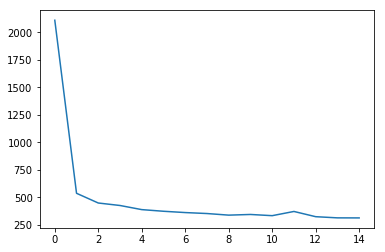

In [21]:
costs = []
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)

    for i in range(max_iter):
        for j in range(n_batches):
            Xbatch = Xtrain[j*batch_sz:(j*batch_sz + batch_sz),]
            Ybatch = Ytrain_ind[j*batch_sz:(j*batch_sz + batch_sz),]

            session.run(train_op, feed_dict={X: Xbatch, T: Ybatch})
            if j % print_period == 0:
                test_cost = session.run(cost, feed_dict={X: Xtest, T: Ytest_ind})
                prediction = session.run(predict_op, feed_dict={X: Xtest})
                err = error_rate(prediction, Ytest)
                print("Cost / err at iteration i=%d, j=%d: %.3f / %.3f" % (i, j, test_cost, err))
                costs.append(test_cost)

plt.plot(costs)
plt.show()